# Frequency Sweeps of Ground and Excited States

## Imports and Data Processing

### Imports and Reading in Data

In [2]:
!pip install 

In [5]:
import scipy
import pickle
import matplotlib.pyplot as plt
import numpy as np
import json
import math as m
from scipy.fft import fft, fftfreq, fftshift
import circle_fit
import sys
#from qtrl.qtrl.fitting.resonator_fitting import resonator_regression
# from qtrl.qtrl import utils
from qtrl.fitting import resonator_fitting
#loads all data and then averages over individual trials
# with open('Data/july_13_Freq_Sweep.pkl', 'rb') as f:
#     data = pickle.load(f)

### Time Delay (from previous run)

In [14]:
#obtained from 06013 run and copied in
t_delay = -6.792439096811805e-07 #REAL - DO NOT CHANGE 

# t_delay = -6.892439096811805e-07 #FAKE - DELETE

#This function can/should be simplifed - overcomplicated def
def unwinding_phase(i):
    phases_unzeroed = 2*m.pi*(data['Frequencies'])*t_delay
    phases_zeroed = phases_unzeroed - phases_unzeroed[0]
    phases_zeroed = np.moveaxis(np.broadcast_to(phases_zeroed,(2,np.size(data['Data'][:,0,0]))),0,1)
    proper_phases = phases_zeroed + (np.angle(data['Data'][i,0,:] + 1j*data['Data'][i,1,:])[0,:])
    return phases_zeroed

#need to multiply by magnitude of vector
def unwinding_IQ():
    for i in range(np.size(data['Data'][:,0,0])):
        S21 = data['Data'][i,0,:] + 1j*data['Data'][i,0,:]
        S21_unwound = S21*np.exp(-1j*unwinding_phase(i))
        unwound_data[data['Qname']] = np.array([np.real(S21_unwound), np.imag(S21_unwound)])

## Plots

### Frequency Sweeps of Ground and Excited Qubits

KeyError: 'I'

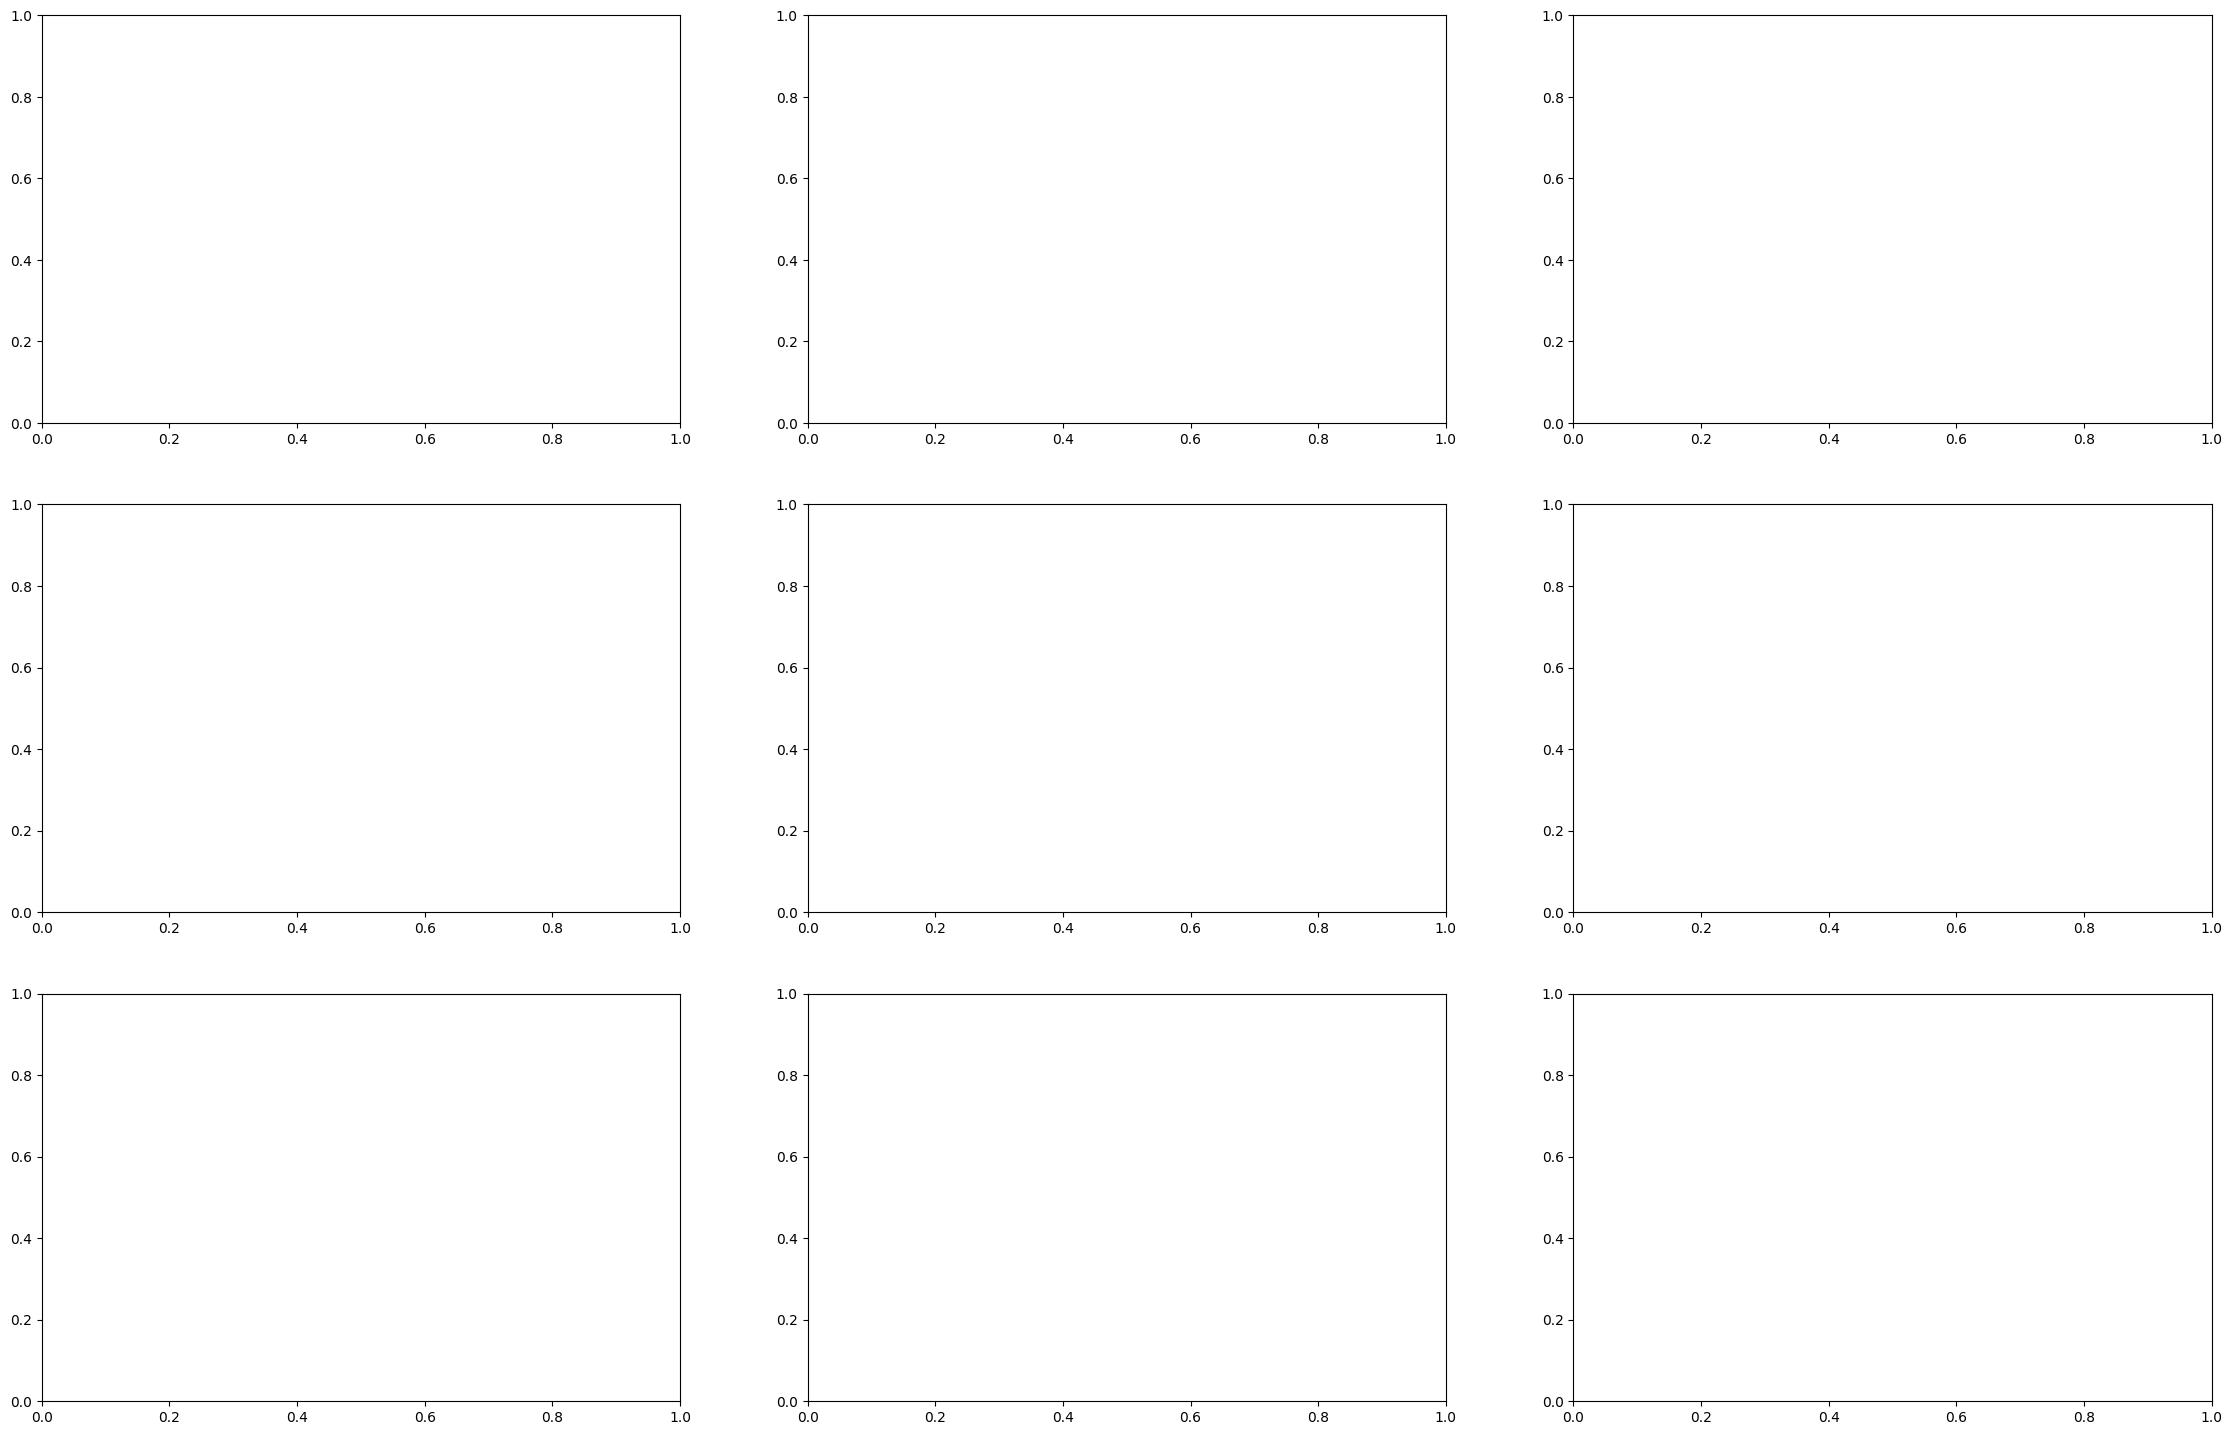

In [15]:
fig, ax = plt.subplots(3,3, figsize = (28,18))
ax = np.ndarray.flatten(ax)

for i in range(np.size(data['qubits'])):
    ax[i].plot(data['Frequencies'], data['Data'][[:,((data['I'][i,:,:]**2 + data['Q'][i,:,:]**2)**0.5)[:,0], label = str(data['qubits'][i]) + ' g')
    ax[i].plot(data['Frequencies'], ((data['I'][i,:,:]**2 + data['Q'][i,:,:]**2)**0.5)[:,1], label = str(data['qubits'][i]) + ' e')
    ax[i].grid()
    ax[i].set(
    title = 'Frequency Sweep Through Resonance',
    xlabel = 'Frequency (Hz)',
    ylabel = '(I^2 + Q^2)^0.5')
    ax[i].legend()
    # ax[i].set_yscale('log')

ax[8].axis('off');

### I/Q Resonant Circles for Ground and Excited Qubits (Reduced Data)

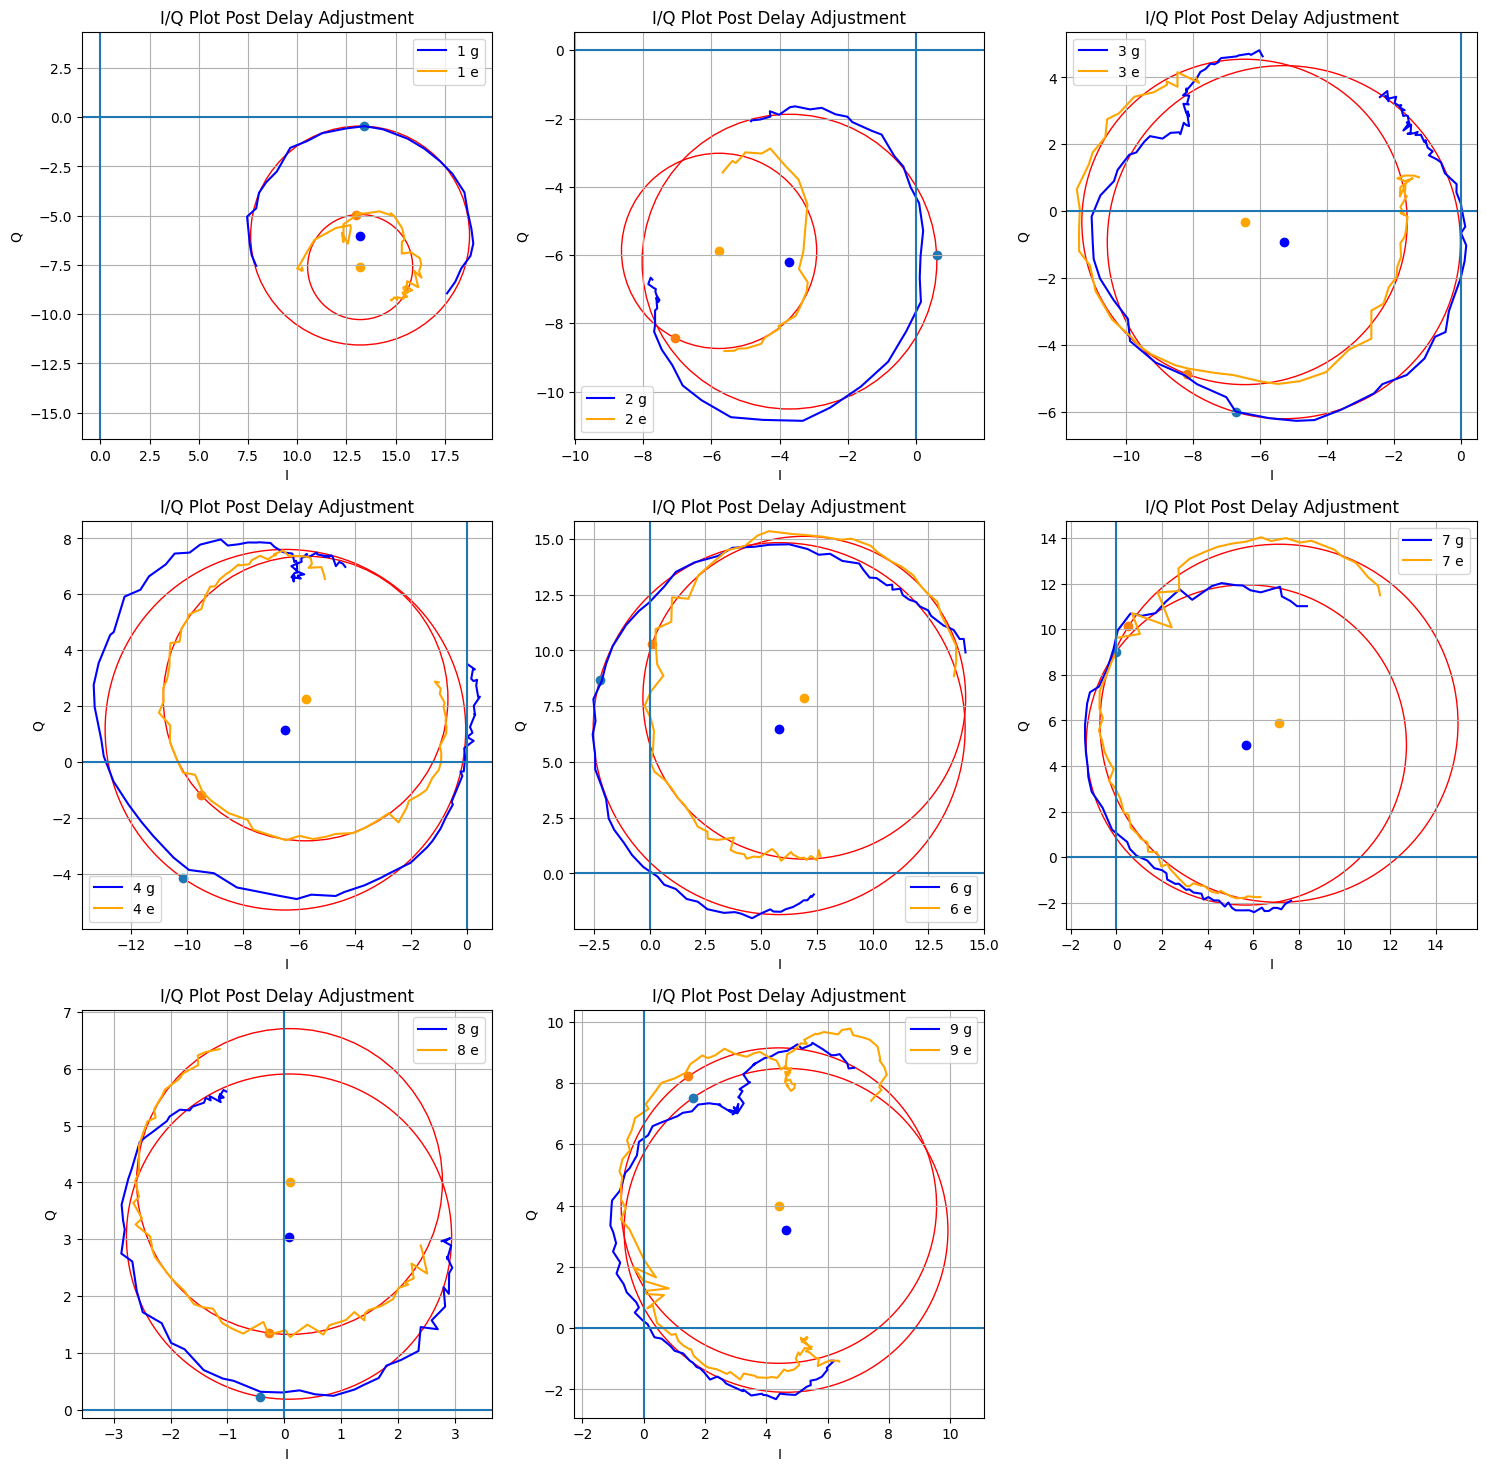

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#[qubit #, g/e,lower/upper index]
artisanal_range = np.array([[[208,235],[160,215]],
               [[212,260],[185,210]],
               [[155,270],[152,210]],
               [[148,258],[110,190]],
               [[180,254],[135,205]],
               [[175,240],[140,205]],
               [[205,265],[155,212]],
               [[145,250],[100,240]]])

ground_fit = {}
excited_fit = {}
g_fit_pars = {}
e_fit_pars = {}
g_f_res = {}
e_f_res = {}
g_res_angle = {}
e_res_angle = {}
g_stat_angle = {}
e_stat_angle = {}
g_stat_point = {}
e_stat_point = {}
g_res_point = {}
e_res_point = {}
xi = {}
g_scaling_factor_plus = {}
g_scaling_factor_minus = {}
e_scaling_factor_plus = {}
e_scaling_factor_minus = {}
g_scaled_rot_fit = {}
e_scaled_rot_fit = {}
bare_cavity = {}

unwound_data = {}
unwinding_IQ()

fig, ax = plt.subplots(3,3, figsize = (18,18))
ax = np.ndarray.flatten(ax)

k = 0
for i in data['qubits']:
    ground_fit[i] = circle_fit.taubinSVD(np.moveaxis([unwound_data[i][0,artisanal_range[k,0,0]:artisanal_range[k,0,1],0],unwound_data[i][1,artisanal_range[k,0,0]:artisanal_range[k,0,1],0]],0,1))
    excited_fit[i] = circle_fit.taubinSVD(np.moveaxis([unwound_data[i][0,artisanal_range[k,1,0]:artisanal_range[k,1,1],1],unwound_data[i][1,artisanal_range[k,1,0]:artisanal_range[k,1,1],1]],0,1))
    circle_g = plt.Circle((ground_fit[i][0], ground_fit[i][1]), ground_fit[i][2], fill = False, linewidth = 1, color = 'red')
    circle_e = plt.Circle((excited_fit[i][0], excited_fit[i][1]), excited_fit[i][2], fill = False, linewidth = 1, color = 'red')
    g_fit_pars[i], _, _ = resonator_fitting.resonator_regression(freq_range_array + data['f0s'][k], unwound_data[i][0,:,0] + 1j*unwound_data[i][1,:,0])
    e_fit_pars[i], _, _ = resonator_fitting.resonator_regression(freq_range_array + data['f0s'][k], unwound_data[i][0,:,1] + 1j*unwound_data[i][1,:,1])
    g_f_res[i] = np.real(g_fit_pars[i][1])
    e_f_res[i] = np.real(e_fit_pars[i][1])
    bare_cavity[i] = (g_f_res[i] + e_f_res[i])/2
    g_index = find_nearest(freq_range_array + data['f0s'][k], g_f_res[i])
    e_index = find_nearest(freq_range_array + data['f0s'][k], e_f_res[i])
    g_res_angle[i] = np.angle((unwound_data[i][0,g_index,0] - ground_fit[i][0]) + 1j*(unwound_data[i][1,g_index,0] - ground_fit[i][1]))
    e_res_angle[i] = np.angle((unwound_data[i][0,e_index,1] - excited_fit[i][0])  + 1j*(unwound_data[i][1,e_index,1] - excited_fit[i][1]))
    g_stat_angle[i] = g_res_angle[i] + m.pi
    e_stat_angle[i] = e_res_angle[i] + m.pi
    g_stat_point[i] = np.asarray([ground_fit[i][0] + ground_fit[i][2]*np.cos(g_stat_angle[i]), ground_fit[i][1] + ground_fit[i][2]*np.sin(g_stat_angle[i])])
    e_stat_point[i] = np.asarray([excited_fit[i][0] + excited_fit[i][2]*np.cos(e_stat_angle[i]), excited_fit[i][1] + excited_fit[i][2]*np.sin(e_stat_angle[i])])
    g_res_point[i] = np.asarray([ground_fit[i][0] + ground_fit[i][2]*np.cos(g_res_angle[i]), ground_fit[i][1] + ground_fit[i][2]*np.sin(g_res_angle[i])])
    e_res_point[i] = np.asarray([excited_fit[i][0] + excited_fit[i][2]*np.cos(e_res_angle[i]), excited_fit[i][1] + excited_fit[i][2]*np.sin(e_res_angle[i])])
    xi[i] = g_f_res[i] - e_f_res[i]
    g_scale = np.sqrt(np.sum(g_stat_point[i]**2))
    e_scale = np.sqrt(np.sum(e_stat_point[i]**2))
    g_scaled_rot_center = (ground_fit[i][0] + 1j*ground_fit[i][1])*np.exp(-1j*np.angle(g_stat_point[i][0] + 1j*g_stat_point[i][1]))/g_scale
    e_scaled_rot_center = (excited_fit[i][0] + 1j*excited_fit[i][1])*np.exp(-1j*np.angle(e_stat_point[i][0] + 1j*e_stat_point[i][1]))/e_scale
    g_scaled_rot_fit[i] = np.array([np.real(g_scaled_rot_center), np.imag(g_scaled_rot_center), ground_fit[i][2]/g_scale, ground_fit[i][3]/g_scale])
    e_scaled_rot_fit[i] = np.array([np.real(e_scaled_rot_center), np.imag(e_scaled_rot_center), excited_fit[i][2]/e_scale, excited_fit[i][3]/e_scale])
    ax[k].add_patch(circle_g)
    ax[k].add_patch(circle_e)
    ax[k].scatter(ground_fit[i][0],ground_fit[i][1], color = 'blue')
    ax[k].scatter(excited_fit[i][0],excited_fit[i][1], color = 'orange')
    ax[k].scatter(g_res_point[i][0],g_res_point[i][1])
    ax[k].scatter(e_res_point[i][0],e_res_point[i][1])
    ax[k].plot(unwound_data[i][0,artisanal_range[k,0,0]:artisanal_range[k,0,1],0], unwound_data[i][1,artisanal_range[k,0,0]:artisanal_range[k,0,1],0], color = 'blue', label = str(i) + ' g')
    ax[k].plot(unwound_data[i][0,artisanal_range[k,1,0]:artisanal_range[k,1,1],1], unwound_data[i][1,artisanal_range[k,1,0]:artisanal_range[k,1,1],1], color = 'orange', label = str(i) + ' e')
    ax[k].grid()
    ax[k].set(
        title = 'I/Q Plot Post Delay Adjustment',
        xlabel = 'I',
        ylabel = 'Q')
    ax[k].set_xlim((-20,20))
    ax[k].set_ylim((-20,20))
    ax[k].axis('equal')
    ax[k].axhline()
    ax[k].axvline()
    ax[k].legend()
    k = k + 1

ax[8].axis('off');

# time_domain = g_f_res
# VNA = {1: 7260845948.975348, 2: 7301084560.038364, 3: 7320982747.161803, 4: 7356372970.4335785, 6: 7413676320.815475, 7: 7439667061.390344, 8: 7473516899.688848, 9: 7497420483.035764}

# for i in VNA:
#     print(time_domain[i]-VNA[i])

### Full I/Q Circles Plotted

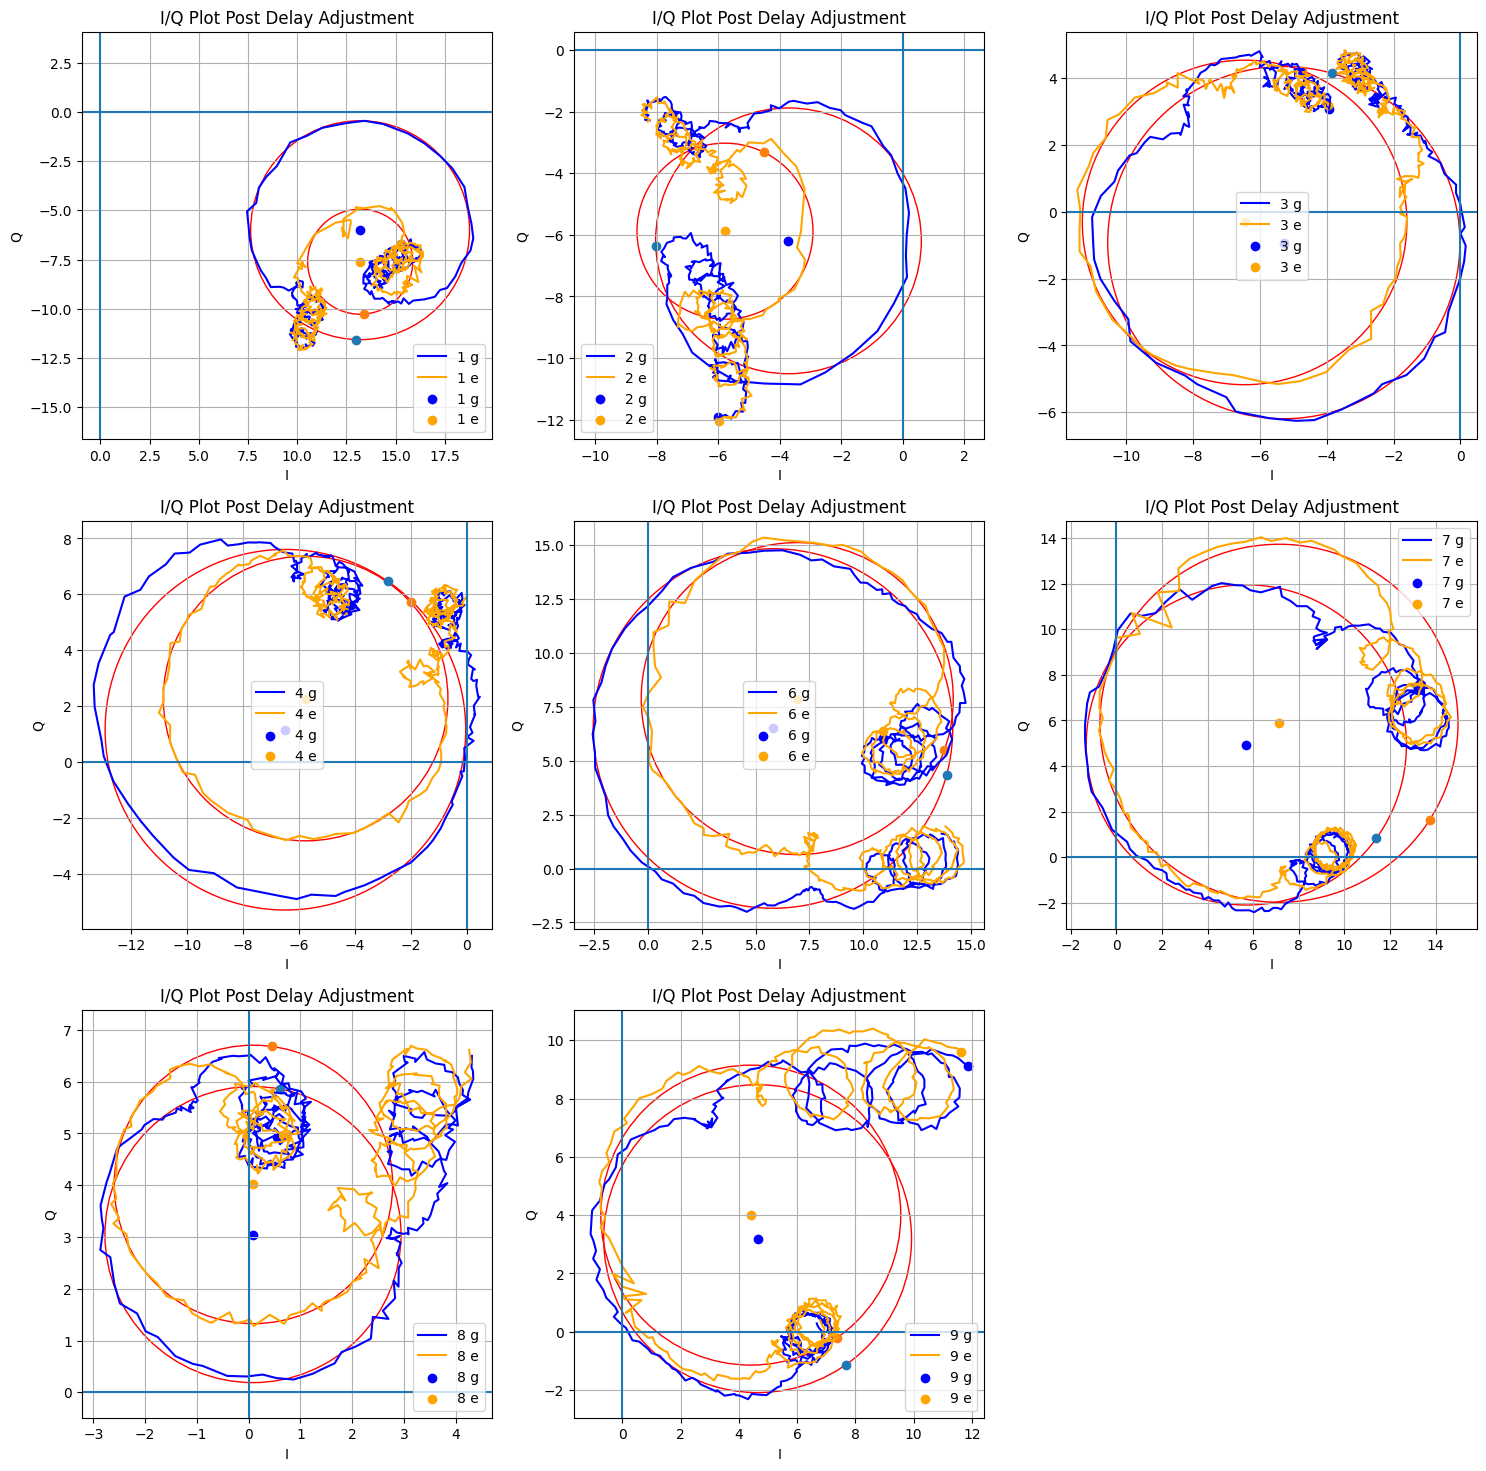

In [12]:
start = 0
end = np.size(data['I'])

fig, ax = plt.subplots(3,3, figsize = (18,18))
ax = np.ndarray.flatten(ax)

k = 0
for i in data['qubits']:
    circle_g = plt.Circle((ground_fit[i][0], ground_fit[i][1]), ground_fit[i][2], fill = False, linewidth = 1, color = 'red')
    circle_e = plt.Circle((excited_fit[i][0], excited_fit[i][1]), excited_fit[i][2], fill = False, linewidth = 1, color = 'red')
    ax[k].add_patch(circle_g)
    ax[k].add_patch(circle_e)
    ax[k].scatter(g_stat_point[i][0],g_stat_point[i][1])
    ax[k].scatter(e_stat_point[i][0],e_stat_point[i][1])
    ax[k].scatter(ground_fit[i][0],ground_fit[i][1], color = 'blue')
    ax[k].scatter(excited_fit[i][0],excited_fit[i][1], color = 'orange')
    ax[k].plot(unwound_data[i][0,:,0], unwound_data[i][1,:,0], color = 'blue', label = str(i) + ' g')
    ax[k].plot(unwound_data[i][0,:,1], unwound_data[i][1,:,1], color = 'orange', label = str(i) + ' e')
    ax[k].scatter(unwound_data[i][0,0,0], unwound_data[i][1,0,0], color = 'blue', label = str(i) + ' g')
    ax[k].scatter(unwound_data[i][0,0,1], unwound_data[i][1,0,1], color = 'orange', label = str(i) + ' e')
    ax[k].grid()
    ax[k].set(
        title = 'I/Q Plot Post Delay Adjustment',
        xlabel = 'I',
        ylabel = 'Q')
    ax[k].set_xlim((-20,20))
    ax[k].set_ylim((-20,20))
    ax[k].axis('equal')
    ax[k].axhline()
    ax[k].axvline()
    ax[k].legend()
    k = k + 1

ax[8].axis('off');

### Xi by Qubit

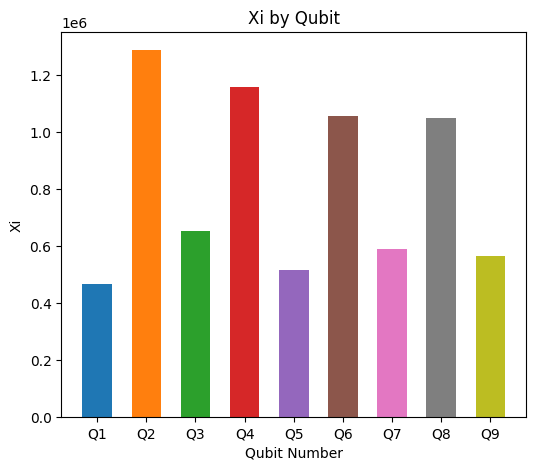

In [13]:
width = 0.6  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(1,1, figsize = (6,5))

for i in xi:
    xi_graph = ax.bar(f'Q{i}', xi[i], width)
    ax.set(
        title = 'Xi by Qubit',
        xlabel = 'Qubit Number',
        ylabel = 'Xi')
    #ax[0].set_yscale('log')
    # kappa_graph = ax[1].bar(f'Q{i}', kappa[i], width)
    # ax[1].set(
    #     title = 'Total Kappa by Qubit',
    #     xlabel = 'Qubit Number',
    #     ylabel = 'Kappa')
    #ax[1].set_yscale('log')
    if i == 4:
        xi_graph = xi_graph + ax.bar('Q5', 515186.8526945114, width) #taken from 06/13 data
        
plt.show()

### Normalized and Rotated I/Q Circle Plots

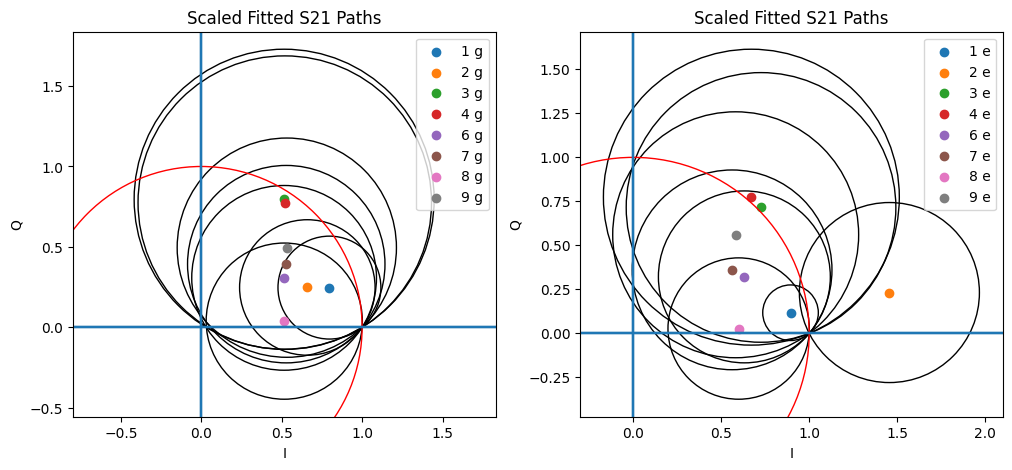

In [14]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

for i in data['qubits']:
    circle_g = plt.Circle((g_scaled_rot_fit[i][0],g_scaled_rot_fit[i][1]), g_scaled_rot_fit[i][2], fill = False, linewidth = 1)
    ax[0].add_patch(circle_g)
    ax[0].scatter(g_scaled_rot_fit[i][0],g_scaled_rot_fit[i][1], label = str(i) + ' g')
    #ax.scatter(e_scaled_rot_fit[i][0],e_scaled_rot_fit[i][1])
    ax[0].grid()
    ax[0].set(
        title = 'Scaled Fitted S21 Paths',
        xlabel = 'I',
        ylabel = 'Q')
    ax[0].set_xlim((0,1))
    ax[0].set_ylim((-1,1))
    ax[0].axis('equal')
    ax[0].axhline()
    ax[0].axvline()
    ax[0].legend()
    
    circle_e = plt.Circle((e_scaled_rot_fit[i][0],e_scaled_rot_fit[i][1]), e_scaled_rot_fit[i][2], fill = False, linewidth = 1)
    ax[1].add_patch(circle_e)
    ax[1].scatter(e_scaled_rot_fit[i][0],e_scaled_rot_fit[i][1], label = str(i) + ' e')
    ax[1].grid()
    ax[1].set(
        title = 'Scaled Fitted S21 Paths',
        xlabel = 'I',
        ylabel = 'Q')
    ax[1].set_xlim((0,1))
    ax[1].set_ylim((-1,1))
    ax[1].axis('equal')
    ax[1].axhline()
    ax[1].axvline()
    ax[1].legend()

unit_circ0 = plt.Circle((0,0),1, fill = False, linewidth = 1, color = 'red')
unit_circ1 = plt.Circle((0,0),1, fill = False, linewidth = 1, color = 'red')
ax[0].add_patch(unit_circ0);
ax[1].add_patch(unit_circ1);

## Junk

In [15]:
first_fraction = round(np.size(unwound_data[0,0,:,0]))
def oscillations(I, I_offset, Q_offset, r):
    return np.sqrt(((I - I_offset)/1)**2 - r**2) + Q_offset


for i in range(np.size(data['qubits'])):
    oscillation_fits = scipy.optimize.curve_fit(oscillations, unwound_data[0,i,0:first_fraction,0], unwound_data[1,i,0:first_fraction,0])

print(oscillation_fits)

TypeError: unhashable type: 'slice'

In [ ]:
def f(freq, a, b, c):
    return 1-((a/b)/(1+2j*a*(freq-c)/c))
scipy.optimize.curve_fit(f,freq,(I,Q))

In [ ]:
#run only to get absolutely fresh data - pickle should be fast and have all the good data in it
path = '/Volumes/Flamingo/Projects/2022-9-qubit-LL/data/session_2023_06_13/2023_06_13/1686701896_readout_calibration'
path2 = '/Volumes/Flamingo/Projects/2022-9-qubit-LL/data/session_2023_06_14/2023_06_14/1686763027_readout_calibration'

nmeas = 100
counter = 2
fts = sorted(os.listdir(path))
data = {}
for q in range(1,6):
    I0s = []
    Q0s = []
    I1s = []
    Q1s = []
    for _ in range(nmeas):
        file_path = os.path.join(path, fts[counter])
        with open(file_path, 'r') as jfile:
            jdata = json.load(jfile)
            I0 = np.array(jdata[f'R{q}']['0']['Heterodyne'])[0,:,0,0]
            Q0 = np.array(jdata[f'R{q}']['0']['Heterodyne'])[1,:,0,0]
            I1 = np.array(jdata[f'R{q}']['0']['Heterodyne'])[0,:,1,0]
            Q1 = np.array(jdata[f'R{q}']['0']['Heterodyne'])[1,:,1,0]

            I0s.append(I0)
            Q0s.append(Q0)
            I1s.append(I1)
            Q1s.append(Q1)
        counter += 2
    data[f'Q{q}'] = np.array([np.array(I0s), np.array(Q0s), np.array(I1s), np.array(Q1s)])

counter = 2
fts = sorted(os.listdir(path2))
for q in range(6,10):
    I0s = []
    Q0s = []
    I1s = []
    Q1s = []
    for _ in range(nmeas):
        file_path = os.path.join(path2, fts[counter])
        with open(file_path, 'r') as jfile:
            jdata = json.load(jfile)
            I0 = np.array(jdata[f'R{q}']['0']['Heterodyne'])[0,:,0,0]
            Q0 = np.array(jdata[f'R{q}']['0']['Heterodyne'])[1,:,0,0]
            I1 = np.array(jdata[f'R{q}']['0']['Heterodyne'])[0,:,1,0]
            Q1 = np.array(jdata[f'R{q}']['0']['Heterodyne'])[1,:,1,0]

            I0s.append(I0)
            Q0s.append(Q0)
            I1s.append(I1)
            Q1s.append(Q1)
        counter += 2
    data[f'Q{q}'] = np.array([np.array(I0s), np.array(Q0s), np.array(I1s), np.array(Q1s)])
    
properform = {}
for key in data:
    properform[key] = np.stack((data[f'Q{q}'][0:2,:,:], data[key][2:4,:,:]), axis = -1)
    
fileObj = open('full_res_freq_sweep.pkl', 'wb')
pickle.dump(properform,fileObj)
fileObj.close()

In [ ]:
# here in case I need it
def simple_fft(
    ts: np.ndarray,
    ys: np.ndarray,
    axis: int = -1,
    subtract_mean: bool = True,
) -> tuple[np.array, np.array]:
    """Helper function for computing FFT's.

    Uses scipy.fft.fft to perform an fft, and returns both the frequency domain
    data as well as the sampled frequencies in units of Hz (1/s) assuming
    `ts` is given in seconds. The DC offset can be optionally subtracted before
    computing fourier transform.

    Args:
        ts: The array of time values. The sample spacing should be equal but this
            is not verified.
        ys: The array of time domain.
        subtract_mean: If true, the mean of ys will be subtracted before computing
            the fft.

        Returns:
            A tuple with the sampled frequency array and the frequency domain
            data.
    """
    ys = np.asarray(ys)
    if subtract_mean:
        ys = ys - np.mean(ys, axis=axis, keepdims=True)

    yfs = fft(ys, axis=axis)
    fs = fftfreq(yfs.shape[axis], ts[1] - ts[0])

    return fftshift(fs), fftshift(yfs, axes=axis)

#Used for filtering out slightly lower period oscillations at tails of signal
k = 0
for key in data['qubits']:
    omegas_omega, complex_fft_out = simple_fft(2*m.pi*(freq_range_array + data['f0s'][k]), unwound_data[key][0,:,0] + 1j*unwound_data[key][1,:,0])
    complex_fft_out = complex_fft_out[200:]
    complex_fft_out[11] = 0
    omega, data_filtered = simple_fft(omegas_omega, complex_fft_out)
    filtered_I = np.real(data_filtered)
    filtered_Q = np.imag(data_filtered)
    #unwound_data[key][0,:,0]
    fig, ax = plt.subplots()
    ax.plot(filtered_I, filtered_Q)
    ax.axis('equal')
    plt.show()
    k = k + 1

k = 0
for key in data['qubits']:
    omegas_omega, complex_fft_out = simple_fft(2*m.pi*(freq_range_array + data['f0s'][k]), unwound_data[key][0,:,1] + 1j*unwound_data[key][1,:,1])
    complex_fft_out = complex_fft_out[200:]
    complex_fft_out[11] = 0
    omega, data_filtered = simple_fft(omegas_omega, complex_fft_out)
    filtered_I = np.real(data_filtered)
    filtered_Q = np.imag(data_filtered)
    unwound_data[key][:,:,1] = np.array([filtered_I,filtered_Q])
    fig, ax = plt.subplots()
    ax.plot(filtered_I[:,0], filtered_Q[:,0])
    ax.axis('equal')
    plt.show()
    k = k + 1   